### Sample Data Example

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

- 가상으로 생성할 데이터의 boundary & 데이터 생성 시 사용할 noise 수치 결정
- 데이터 생성 위한 가상의 함수 func 생성
- 훈련 데이터로 사용할 x_tr과 x_tr을 func 함수에 적용한 y_tr 생성
- boundary에서 일정한 간격으로 데이터를 생성

In [2]:
bounds = np.array([[-3.0,4.0]])
noise = 0.2

def func(x, noise = noise) :
    return np.sin(x) + noise*np.random.randn(*x.shape)

x_tr = np.array([[-0.9],[1.4]])
y_tr = func(x_tr)

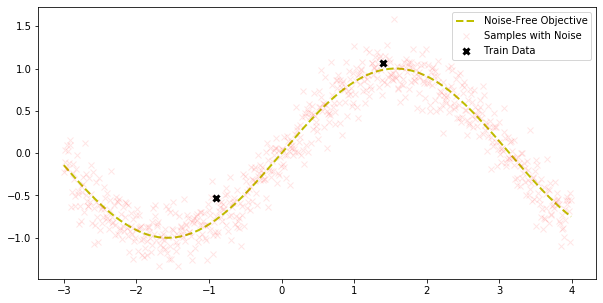

In [3]:
x = np.arange(bounds[:,0], bounds[:,1], 0.01).reshape(-1,1)
y = func(x,0)

plt.figure(figsize = (10,5))
plt.plot(x,y, 'y--', lw = 2, label = 'Noise-Free Objective')
plt.plot(x, func(x), 'rx', lw = 1, alpha = 0.1, label = 'Samples with Noise')
plt.plot(x_tr, y_tr, 'kx', mew = 3, label = 'Train Data')
plt.legend()

In [4]:
import GPy
import GPyOpt
from GPyOpt.methods import BayesianOptimization

- Surrogate Function으로 Gaussian Process를 활용하며 RBF 커널에 대한 parameter를 다음과 같이 정의

In [5]:
kernel = GPy.kern.RBF(input_dim = 1, variance = 1.0, lengthscale = 1.0)

In [6]:
bds = [
    {'name' : 'x'
    ,'type' : 'continuous'
    ,'domain' : bounds.ravel()}]

In [7]:
optimizer = BayesianOptimization(f = func
                                , domain = bds
                                , model_type = 'GP'
                                , kernel = kernel
                                , acquisition_type = 'EI'
                                , acquisition_jitter = 0.01
                                , x = x_tr
                                , y = y_tr
                                , noise_var = noise**2
                                , exact_feval = False
                                , normalize_Y = False
                                , maximize = True)

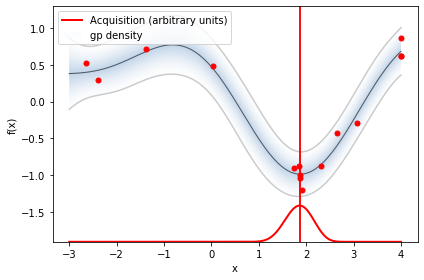

In [8]:
optimizer.run_optimization(max_iter = 10)
optimizer.plot_acquisition()

In [9]:
print("Optimal value of x : {:.4f}".format(optimizer.x_opt[-1]))
print("Maximum value of y : {:.4f}".format(max(-optimizer.Y)[-1]))

Optimal value of x : 1.9162
Maximum value of y : 1.2014


In [10]:
optimizer.get_evaluations()[0].flatten()

array([-2.39148152, -2.63974987, -1.36957432,  0.02965235,  3.06847225,
        4.        ,  3.99440327,  3.99212153,  2.65135593,  2.31564821,
        1.91618116,  1.75183234,  1.84246048,  1.87147656,  1.86858103])

In [11]:
-optimizer.get_evaluations()[1].flatten()

array([-0.28987843, -0.52019255, -0.71789323, -0.4802334 ,  0.28741629,
       -0.6142875 , -0.87088048, -0.6192458 ,  0.4271359 ,  0.88287828,
        1.20144076,  0.90597396,  0.87996547,  1.00373641,  1.03964039])

Text(0.5, 1.0, 'Cumulative Maximum Value of y')

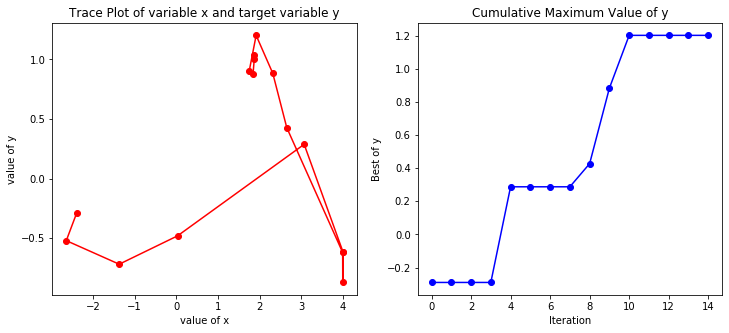

In [12]:
plt.figure(figsize = (12,5))
plt.subplot(1,2,1)
plt.plot(optimizer.get_evaluations()[0].flatten(),-optimizer.get_evaluations()[1].flatten(), 'ro-')
plt.xlabel('value of x')
plt.ylabel('value of y')
plt.title('Trace Plot of variable x and target variable y')

plt.subplot(1,2,2)
plt.plot(np.maximum.accumulate(-optimizer.Y).ravel(), 'bo-', label='Bayesian optimization')
plt.xlabel('Iteration')
plt.ylabel('Best of y')
plt.title('Cumulative Maximum Value of y')

### Bayesian Optimization Application
- hyperparameter tuning 과정에서 Bayesian Optimization 사용되는 과정 살펴보기
- XGBoost 와 GPyOpt 패키지를 사용해서 모델 적합 과정에서 Bayesian Optimization을 어떻게 사용하는지 확인

In [13]:
from sklearn import datasets
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
from scipy.stats import uniform
from xgboost import XGBRegressor

In [14]:
x, y = datasets.load_diabetes(return_X_y = True)

In [15]:
xgb = XGBRegressor(silent = True)
baseline = cross_val_score(xgb, x, y, scoring = 'neg_mean_squared_error').mean()

#### 왜 negative MSE 인가?

- cross_val_score같은 경우, Negative MSE를 바탕으로 비교해야 함
- score 출력 시, 가장 높은 수치의 score를 출력하도록 cross_val_score 함수가 설계가 되어있기 때문
- 그러나 성능 검증 시, MSE는 작을수록 더 좋기 때문에 음수를 붙인 값을 출력하도록 해야 값이 큰 결과를 반환할 수 있다.
- MSE가 각 [100,200,300] 일 때, 우리는 MSE=100을 만드는 hyperparameter를 받아야하는데 cross_val_score 함수는 300을 최적으로 반환하도록 설계
- 따라서 이 값에 음수를 붙일 경우 -100을 반환하므로 원하는 hyperparameter를 얻을 수 있다. 

#### Random Search를 이용한 hyperparameter tuning
- hyperparameter를 탐색할 hyperparameter space 사전 정의
- Random Search를 진행할 때, 기준이 될 score는 negative mean sqaured error
- 총 200회의 Random Search 진행

In [113]:
params_dist = {
    'learning_rate' : uniform(0,1),
    'gamma' : uniform(0,2),
    'max_depth' : range(1,10),
    'n_estimators' : range(30,100),
    'min_child_weight' : range(1,10)    
}

In [114]:
start = time.time()

rs = RandomizedSearchCV(xgb, param_distributions = params_dist, scoring = 'neg_mean_squared_error', n_iter = 200, n_jobs = -1)
rs.fit(x,y)

print("time sepnt : {:.4f}".format(time.time() - start), "sec")

time sepnt : 11.2838 sec


#### Grid Search를 이용한 hyperparameter tuning
- hyperparamter를 탐색할 hyperparameter space를 사전 정의
- 탐색할 hyerparameter에 대한 간격 지정 / 내가 부여한 hyperparameter에 case만큼 다 탐색
- 마찬가지로 Grid Search 진행 시, 기준이 될 score는 negative mean squared error

In [115]:
params_grid = {
    'learning_rate' : np.arange(0,1,0.5),
    'gamma' : np.arange(0,2,0.5),
    'max_depth' : np.arange(1,10,1),
    'n_estimators' : np.arange(30,100,10),
    'min_child_weight' : np.arange(1,10,1)    
}

In [116]:
start = time.time()

gs = GridSearchCV(xgb, param_grid = params_grid, scoring = 'neg_mean_squared_error', n_jobs = -1)
gs.fit(x,y)

print("time sepnt : {:.4f}".format(time.time() - start), "sec")

time sepnt : 227.2749 sec


#### Bayesian Optimization을 이용한 hyperparameter tuning
- hyperparameter에 대한 데이터 타입과 boundary 설정
- hyperparameter 탐색 시, 사용할 스코어를 함수로 정의 (cv_score)
- BayeisanOptimization 함수의 기본 옵션이 5개의 데이터를 사용하므로 run_optimization() 함수 사용할 때는 max_iter횟수를 5회 차감한 값으로 입력 (200회 하고 싶으니까 195회)

In [18]:
import GPy
import GPyOpt
from GPyOpt.methods import BayesianOptimization

In [117]:
bounds = [
    {'name' : 'learning_rate', 'type' : 'continuous', 'domain' : (0,1)},
    {'name' : 'gamma', 'type' : 'continuous', 'domain' : (0,2)},
    {'name' : 'max_depth', 'type' : 'discrete', 'domain' : (1,10)},
    {'name' : 'n_estimators', 'type' : 'discrete', 'domain' : (30,100)},
    {'name' : 'min_child_weight', 'type' : 'discrete', 'domain' : (1,10)}    
]

- Optimization이 필요한 objective function에 대한 정의

In [78]:
def cv_score(parameters) : 
    parameters = parameters[0]
    score = cross_val_score(XGBRegressor(silent = True,
                                        learning_rate = parameters[0],
                                         gamma = int(parameters[1]),
                                         max_depth = int(parameters[2]),
                                         n_estimators = int(parameters[3]),
                                         min_child_weight = parameters[4]),
                            x, y, scoring = 'neg_mean_squared_error').mean()
    score = np.array(score)
    return score

In [118]:
optimizer = BayesianOptimization(f = cv_score
                                , domain = bounds
                                , model_type = "GP"
                                , acquisition_type = "EI"
                                , acquisition_jitter = 0.01
                                , exact_feval = False
                                , normalize_Y = False
                                , maximize = True)

In [119]:
start = time.time()

optimizer.run_optimization(max_iter = 195)

print("time sepnt : {:.4f}".format(time.time() - start), "sec")

time sepnt : 175.6181 sec


### 3가지 방법 간의 성능 비교
- 가장 높은 negative MSE 값을 기록한 hyperparameter 방법이 성능이 좋다고 볼 수 있다
- 서로 비슷한 negative MSE를 기록한다면, 더 짧은 iteration 안에 최적의 값을 찾아낸 방법이 더 좋다고 볼 수 있다
- Bayesian Optimization이 가장 높은 negative MSE 값을 기록했으며
- Grid Search의 경우, 200회 시행까지 Random Search, Bayesian Optimization 초기 값만큼의 성능을 따라오지 못했다.
- 성능적인 측면, 계산의 효율성을 동시에 고려한다면 Bayesian Optimization을 사용하는 것이 합리적인 것으로 보인다.

In [120]:
y_rs = np.maximum.accumulate(rs.cv_results_['mean_test_score'])
y_gs = np.maximum.accumulate(gs.cv_results_['mean_test_score'])
y_bo = np.maximum.accumulate(-optimizer.Y).ravel()

print(f'Baseline neg.MSE = {baseline:.2f}')
print(f'Random Search neg.MSE = {y_rs[-1]:.2f}')
print(f'Grid Search neg.MSE = {y_gs[-1]:.2f}')
print(f'Bayesian Optimization neg.MSE = {y_bo[-1]:.2f}')

Baseline neg.MSE = -3437.07
Random Search neg.MSE = -3182.50
Grid Search neg.MSE = -3249.59
Bayesian Optimization neg.MSE = -3150.31


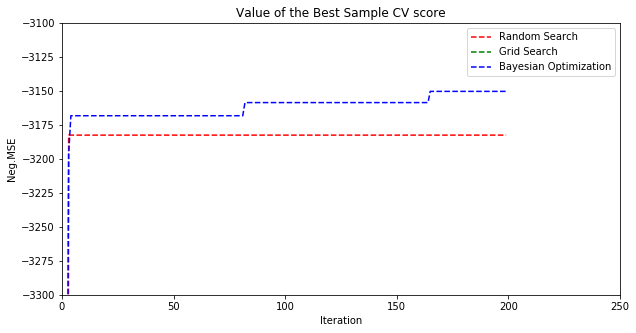

In [140]:
plt.figure(figsize = (10,5))
plt.plot(y_rs, 'r--', label = 'Random Search')
plt.plot(y_gs, 'g--', label = 'Grid Search')
plt.plot(y_bo, 'b--', label = 'Bayesian Optimization')
plt.xlabel('Iteration')
plt.ylabel('Neg.MSE')
plt.xlim(0,250)
plt.ylim(-3300, -3100)
plt.title('Value of the Best Sample CV score')
plt.legend()

#### Bayesian Optimization으로 인해 결정된 최적의 hyperparameter 확인 

In [138]:
print("Optimal hyperparameter value of learning rate : {:.2f}".format(optimizer.x_opt[0]))
print("Optimal hyperparameter value of gamma : {:.2f}".format(optimizer.x_opt[1]))
print("Optimal hyperparameter value of max_depth : {:.2f}".format(optimizer.x_opt[2]))
print("Optimal hyperparameter value of n_estimators : {:.2f}".format(optimizer.x_opt[3]))
print("Optimal hyperparameter value of min_child_weight : {:.2f}".format(optimizer.x_opt[4]))

Optimal hyperparameter value of learning rate : 0.15
Optimal hyperparameter value of gamma : 1.75
Optimal hyperparameter value of max_depth : 1.00
Optimal hyperparameter value of n_estimators : 100.00
Optimal hyperparameter value of min_child_weight : 10.00
